Based on [Pytorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) writen by [Alexis Jacq](https://alexis-jacq.github.io/)

In [2]:
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 8, 8


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
imsize = 256

im_loader = transforms.Compose([
            transforms.Resize(imsize),  # нормируем размер изображения
            transforms.CenterCrop(imsize),
            transforms.ToTensor()])  # превращаем в удобный формат

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def image_loader(image_name):
    image = Image.open(image_name)
    image = im_loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img_local = image_loader("images/mozaic.jpg")
style_img_global = image_loader("images/spiral.jpg")
content_img = image_loader("images/cat.jpg")

Lets apply style of two different pictures to image of cute cat. From the first one we will take local design properties using upper convolutional layers. Second picture will be used for global style trasfer using more abstract features of deeper layers of cnn.

In [5]:
def imshow(tensor, title=None, wait=False):
    image = tensor.cpu().detach()  
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = image.numpy().transpose((1,2,0))
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if wait:
        plt.pause(0.01)

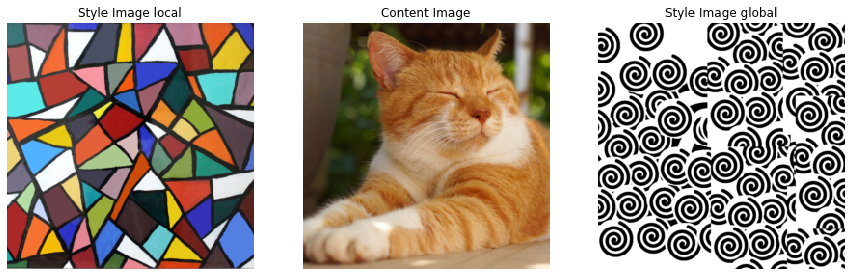

In [6]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
imshow(style_img_local, title='Style Image local')

plt.subplot(1,3,2)
imshow(content_img, title='Content Image')

plt.subplot(1,3,3)
imshow(style_img_global, title='Style Image global')

In [7]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = torch.rand(1)

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [8]:
def gram_matrix(input):
    
        batch_size , features_num, h, w = input.shape
        
        flatten_features = input.view(batch_size * features_num, h * w)  # resise F_XL into \hat F_XL

        G = torch.mm(flatten_features, flatten_features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        
        return G.div(batch_size * features_num * h * w)

In [9]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = torch.rand(1) # to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [10]:
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

In [11]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).to(device).view(-1, 1, 1).detach()
            self.std = torch.tensor(std).to(device).view(-1, 1, 1).detach()

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Lets use VGG19 pretrained cnn 

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

![VGG image](https://pytorch.org/assets/images/vgg.png)

In [13]:
# lets divide style layers into two groups:
# local - convolution layers with narrow perception field < 20 pixels.
# Such layers detect local style patterns such as colour, border types, local pixel structures
#
# global - convolution layers with spacious perception field > 50 pixels
# Such layers detect global style patterns occupying all picture 
# like different animal's body parts, complex geometric forms of bodies 

content_layers_default = ['conv_10']
style_layers_global  = ['conv_5', 'conv_9', 'conv_13', 'conv_14']
style_layers_local = ['conv_1', 'conv_3']

style_layers = {**{st:'global' for st in style_layers_global},
                **{st:'local' for st in style_layers_local}}

In [14]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img_local, style_img_global,
                                   content_img,
                                   content_layers=content_layers_default,
                                   style_layers_local=style_layers_local,
                                   style_layers_global=style_layers_global
                              ):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        # style losses is divided into two groups: local, global
        content_losses = []
        style_losses = {'local':[], 'global':[]}

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = (model(style_img_local).detach() 
                                  if style_layers[name]=='local' 
                                  else model(style_img_global).detach())
                
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss{}".format(i), style_loss)
                style_losses[style_layers[name]].append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [15]:
def get_input_optimizer(input_img, lr = 0.1):
        # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr = lr) 
        return optimizer

In [16]:
from IPython.display import clear_output

def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img_local, style_img_global, input_img, num_steps=500,
                        style_weight=100, local_image_ratio=0.5, content_weight=1, lr=0.1):
        """
        Run the style transfer.
        Parameters
        ----------
        cnn : convolution neural network for feature extraction and loss calculation.
        normalization_mean, normalization_std : normalization parameters that were used for cnn pretrain
        content_img      : image containing the desired content.
        style_img_local  : image containing the desired local style
        style_img_global : image containing the desired global style
        input_img        : input image for style transfer procedure
        num_steps        : numer of optimizer steps
        style_weight     : multiplicator of style loss
        local_image_ratio: the number of importance of local style over global
                           losses will be multiplied as follows 
                           (style_score_global*(1-local_image_ratio) + 
                               style_score_local * local_image_ratio)*style_weight
        content_weight   : multiplicator of content loss
        lr               : learning rate of LBFGS optimizer algorithm
                           
        """
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img_local, style_img_global, content_img)
        optimizer = get_input_optimizer(input_img, lr)

        print('Optimizing..')
        run = [0]
        
        scale_local = 1
        scale_global = 1
        
        while run[0] <= num_steps:
            
            def closure():
                # correct the values 
                global scale_local, scale_global
                
                input_img.data.clamp_(0, 1)
                
                optimizer.zero_grad()

                model(input_img)

                style_score={'local': 0, 'global':0}
                content_score = 0
                
                for type, sl_list in style_losses.items():
                    for sl in sl_list:
                        style_score[type] += sl.loss
                
                # Lets normalize local and global losses by 1 in case of
                # enormous style differences of two images
                
                if run[0] == 0:
                    scale_local  = 1/style_score['local'].item()
                    scale_global = 1/style_score['global'].item() 
                
                style_score['local']  *= scale_local
                style_score['global'] *= scale_global
                
                style_score = (style_score['global']*(1-local_image_ratio) + 
                               style_score['local'] * local_image_ratio)*style_weight
                
                for cl in content_losses:
                    content_score += cl.loss
                    
                content_score *= content_weight
                
                # Summarize content and style losses
                
                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 10 == 0:
                    clear_output(wait=True)
                    imshow(input_img, title="run {}:".format(run) + 'Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()), wait=True)

                return style_score + content_score
                
            optimizer.step(closure)
        # a last correction...
        input_img.data.clamp_(0, 1)
        clear_output(wait=True)
        imshow(input_img, title="Final:", wait=True)

        return input_img

In [17]:
torch.cuda.empty_cache()

# First example

## Lets see the result of applying style only from abstract image_1 on every style layer

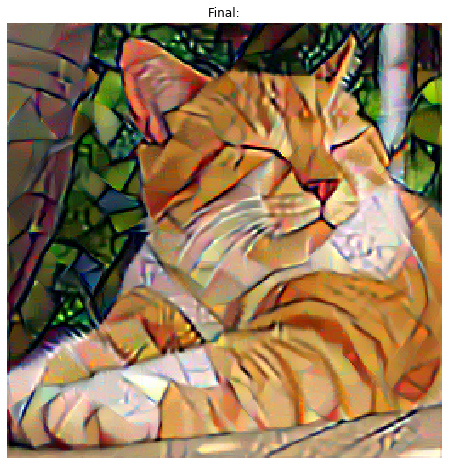

In [18]:
input_img = content_img.clone()
output_img_1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, 
                            style_img_local=style_img_local,
                            style_img_global=style_img_local,
                            input_img=input_img, 
                            num_steps=300, 
                            style_weight=1e4, 
                            local_image_ratio=0.5,
                            content_weight=1,
                            lr = 0.05)

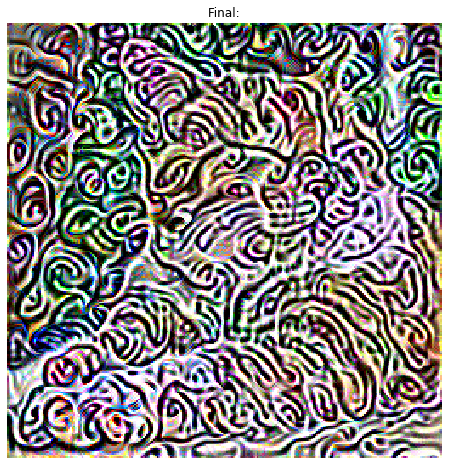

In [19]:
input_img = content_img.clone()
output_img_2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, 
                            style_img_local=style_img_global,
                            style_img_global=style_img_global,
                            input_img=input_img, 
                            num_steps=300, 
                            style_weight=1e4, 
                            local_image_ratio=0.5,
                            content_weight=1,
                            lr = 0.05)

## Now lets apply spirals as local style image and mozaic as global style image

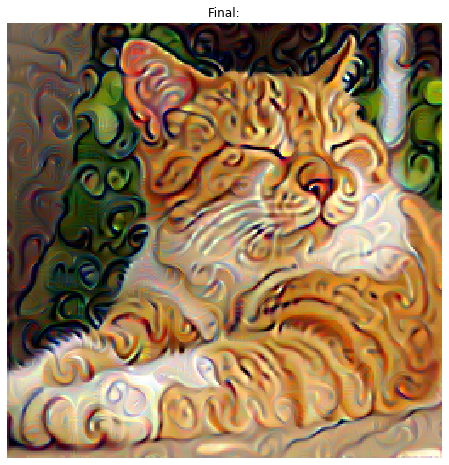

In [20]:
input_img = content_img.clone()
plt.ion()
output_both = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, 
                            style_img_local=style_img_local,
                            style_img_global=style_img_global,
                            input_img=input_img, 
                            num_steps=300, 
                            style_weight=1e4, 
                            local_image_ratio=0.5,
                            content_weight=1,
                            lr = 0.05)

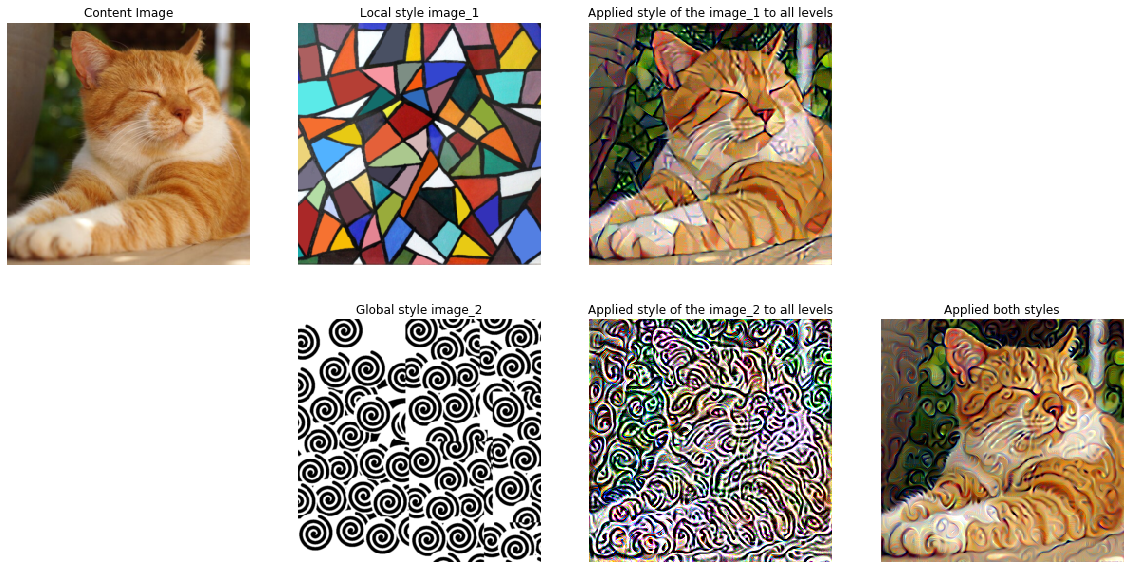

In [21]:
fig = plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
imshow(content_img, title='Content Image')

plt.subplot(2,4,2)
imshow(style_img_local, title='Local style image_1')

plt.subplot(2,4,6)
imshow(style_img_global, title='Global style image_2')

plt.subplot(2,4,3)
imshow(output_img_1, title='Applied style of the image_1 to all levels')

plt.subplot(2,4,7)
imshow(output_img_2, title='Applied style of the image_2 to all levels')

plt.subplot(2,4,8)
imshow(output_both, title='Applied both styles')

One can see that output image has global patterns of spiral image such as global turbulences with same size as perception field of used convolution layer's elements. At the same time local style paterns are the same with mozaic picture: back borders that divide picture to areas with different contrast colours.

# Another example

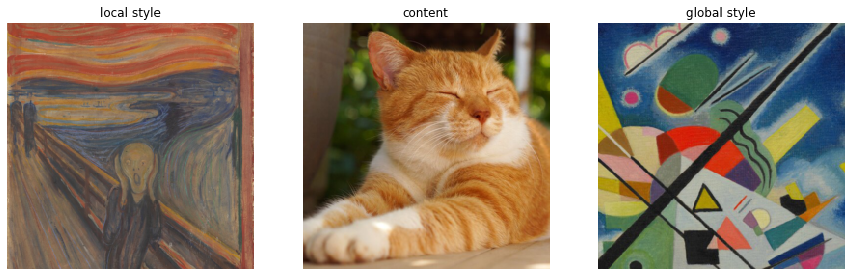

In [67]:
image_local  = image_loader('images/munk.jpg')
image_global = image_loader('images/abstract.jpg')
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
imshow(image_local, 'local style')
plt.subplot(1,3,2)
imshow(content_img, 'content')
plt.subplot(1,3,3)
imshow(image_global, 'global style')

## Lets see the result of applying style only from abstract image_1

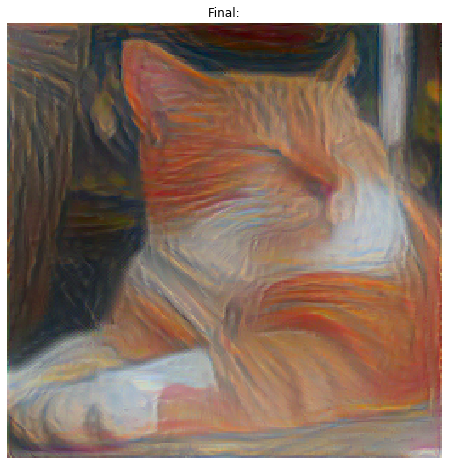

In [68]:
input_img = content_img.clone()
plt.ion()
output_img_1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, 
                            style_img_local=image_local,
                            style_img_global=image_local,
                            input_img=input_img, 
                            num_steps=300, 
                            style_weight=1e4, 
                            local_image_ratio=0.5,
                            content_weight=1,
                            lr = 0.05)

## Lets see the result of applying style only from abstract image_2

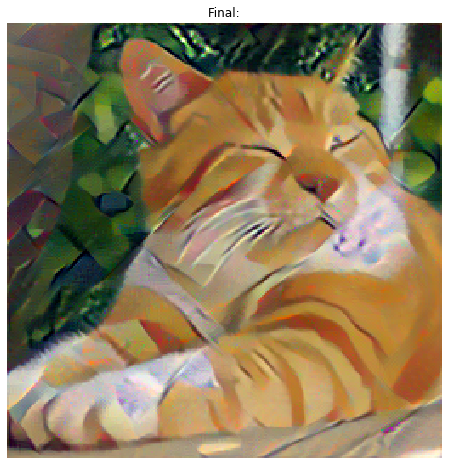

In [69]:
input_img = content_img.clone()
plt.ion()
output_img_2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, 
                            style_img_local=image_global,
                            style_img_global=image_global,
                            input_img=input_img, 
                            num_steps=300, 
                            style_weight=1e4, 
                            local_image_ratio=0.5,
                            content_weight=1,
                            lr = 0.05)

## And finaly both styles

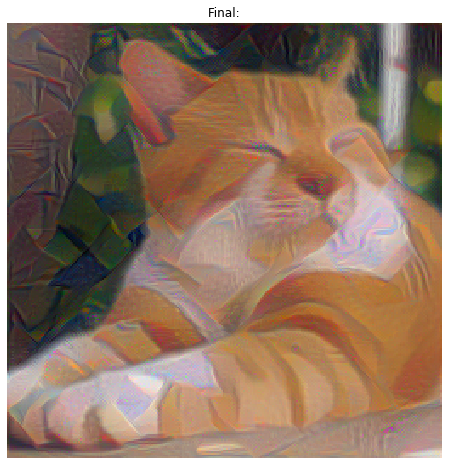

In [70]:
input_img = content_img.clone()
plt.ion()
output_both = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, 
                            style_img_local=image_local,
                            style_img_global=image_global,
                            input_img=input_img, 
                            num_steps=300, 
                            style_weight=1e4, 
                            local_image_ratio=0.5,
                            content_weight=1,
                            lr = 0.05)

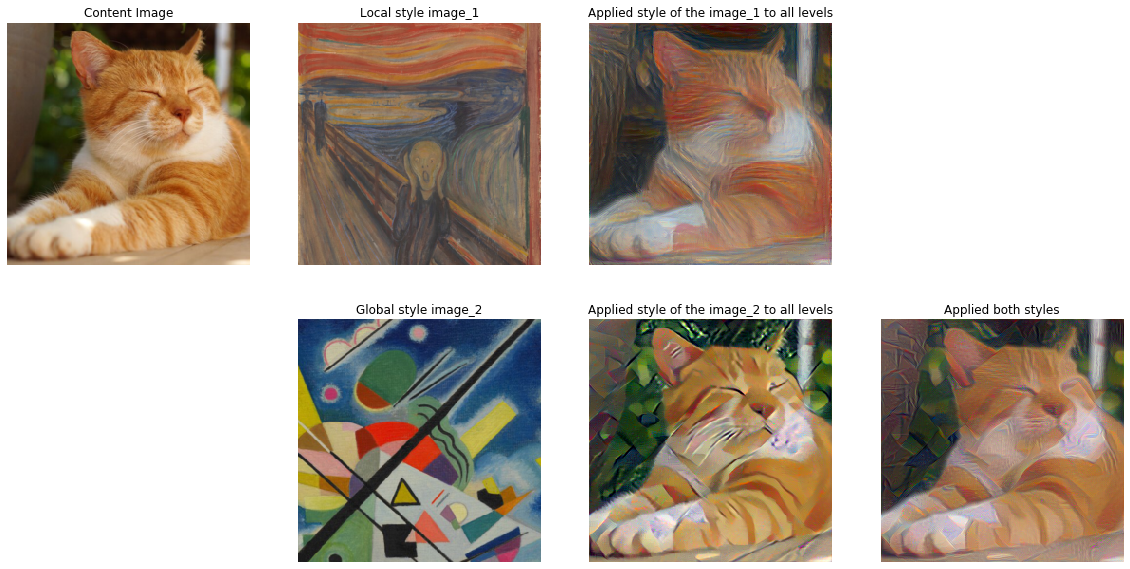

In [72]:
fig = plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
imshow(content_img, title='Content Image')
plt.subplot(2,4,2)
imshow(image_local, title='Local style image_1')
plt.subplot(2,4,3)
imshow(output_img_1, title='Applied style of the image_1 to all levels')
plt.subplot(2,4,7)
imshow(output_img_2, title='Applied style of the image_2 to all levels')
plt.subplot(2,4,6)
imshow(image_global, title='Global style image_2')
plt.subplot(2,4,8)
imshow(output_both, title='Applied both styles')
plt.savefig('cat_stylized_2', dpi = 300)

One can see that output image has global patterns of abstract image such as global image segmentation to simple geometric figues. At the same time local style paterns are the same with Edvard Munch's picture: smoothed coloured lines and light gradients on the borders of different colour elements.